In [1]:
import numpy as np
from scipy.sparse.csgraph import connected_components

from collections import Counter

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from IPython.display import clear_output

In [2]:
# 3 states model:
# - active A -> 1
# - inactive I -> 0
# - refractory R -> -1

def HTC(W, Ts, Tc, cluster=False):
    # PARAMETERS
    dt = 0.1   # timestep
    Nt = 6000  # total number of steps
    N_cluster = 1000
    dt_cluster = int(Nt/N_cluster)
    
    # treshold interval
    W_mean = np.mean(np.sum(W, axis=0))
    Ts = Ts * W_mean
    
    # define empty matrix to store results
    A, sigma_A = [np.zeros(len(Ts)) for _ in range(2)]
    if cluster:
        S1, S2 = [np.zeros(len(Ts)) for _ in range(2)]
        pdf = [Counter() for _ in range(len(Ts))]
    
    # number of random initial configurations
    runs = 100

    # LOOP OVER Ts
    for i,T in enumerate(Ts):
        clear_output(wait=True)
        print(str(i+1) + '/'+ str(len(Ts)) + ': HTC with T = ' +  str(round(T/Tc/W_mean, 2)) + ' * Tc' )

        # initial configurations -> random I and R states
        S = np.random.randint(-1, 2, size=(runs,N))
        s = (S==1).astype(int)

        # create empty array to store activity and cluster size over time
        At = np.zeros((runs, Nt))
        
        if cluster:
            S1t = np.zeros((runs, N_cluster))
            S2t = np.zeros((runs, N_cluster))

        # LOOP OVER TIME
        for t in tqdm(range(Nt)):
            probs = np.random.rand(runs, N)    # generate probabilities

            pA = r1 + (1.-r1) * ( (W@s.T)>T )  # prob. to become active
            
            # UPDATE STATE VECTOR
            S = ( (S==0)*(probs<pA.T)          # I->A
                 + (S==1)*-1                   # A->R
                 + (S==-1)*(probs>r2)*-1 )     # R->I (remain R with prob 1-r2)

            s = (S==1).astype(int)
            
            At[:,t] = np.mean(s, axis=1)       # compute activity
            
            # COMPUTE CLUSTERS
            if cluster and (not t%dt_cluster):
                tempT = t//dt_cluster
                for j in range(runs):
                    mask = W * s[j]            # mask adjacency matrix with active nodes
                    mask = mask.T * s[j]
                    # compute connected components
                    n_components, labels = connected_components(mask, directed=False)
                    # count labels occurrence
                    _, counts = np.unique(labels, return_counts=True)
                    counts = -np.sort(-counts)

                    S1t[j,tempT] = counts[0]
                    S2t[j,tempT] = counts[1]
                    pdf[i] += Counter(counts)
        # END LOOP OVER TIME
            
        # COMPUTE AVERAGES
        A[i] = np.mean(At)
        sigma_A[i] = np.mean( np.std(At, axis=1) )
        if cluster:
            S1[i] = np.mean(S1t)
            S2[i] = np.mean(S2t)
            
    # RETURN RESULTS 
    if cluster:
        return (A, sigma_A, S1/W.shape[0], S2/W.shape[0], pdf)
    else:
        return (A, sigma_A, S1/W.shape[0], S2/W.shape[0])

In [3]:
# Load connectome
cc = np.loadtxt('dati/RSN/RSN_matrix.txt')
cc.shape

(66, 66)

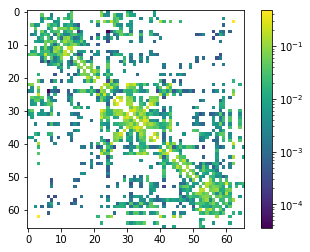

In [4]:
import matplotlib.colors

plt.imshow(cc, norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.show()

In [5]:
N = cc.shape[0]     # number of nodes in the network

# model parameters
r1 = 2./N
r2 = r1**(1./5.)

# critical point (theoretical)
Tc = r2 / (1. + 2.*r2)

# treshold interval (normalized)
dT = 0.05
Ts = np.arange(0., 2.+dT, dT) * Tc

In [6]:
# normalize matrix -> divide by sum of each row
cc_norm = cc / np.sum(cc, axis=0)[:,None]

In [7]:
%%time
A, sigma_A, S1, S2, pdf = HTC(cc, Ts=Ts, Tc=Tc, cluster=True)

41/41: HTC with T = 2.0 * Tc



CPU times: user 2h 13min 38s, sys: 9min 41s, total: 2h 23min 20s
Wall time: 1h 12min 52s


In [9]:
%%time
A_norm, sigma_A_norm, S1_norm, S2_norm, pdf_norm = HTC(cc_norm, Ts=Ts, Tc=Tc, cluster=True)

41/41: HTC with T = 2.0 * Tc



CPU times: user 2h 12min 53s, sys: 9min 36s, total: 2h 22min 30s
Wall time: 1h 12min 26s


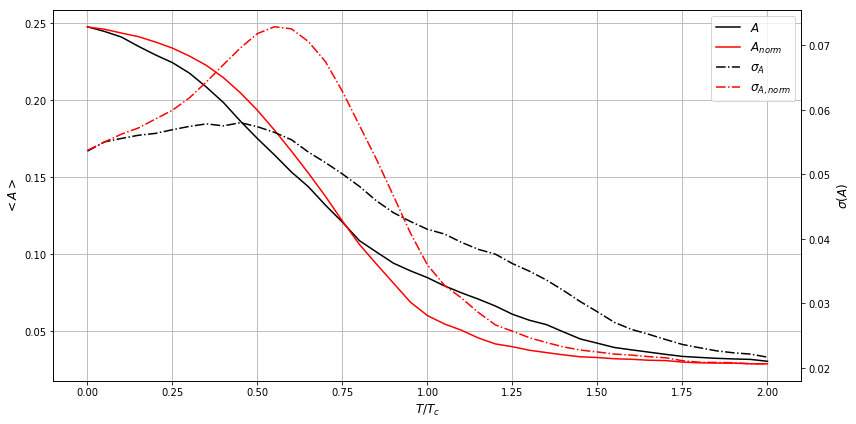

In [108]:
fig, ax1 = plt.subplots(figsize=(12,6))
plt.grid()

ax1.plot(Ts/Tc, A, label=r'$A$', c='black')
ax1.plot(Ts/Tc, A_norm, label=r'$A_{norm}$', c='red')
ax1.set_xlabel(r'$T/T_c$', size=12)
ax1.set_ylabel(r'$<A>$', size=12)

ax2 = ax1.twinx()
ax2.plot(Ts/Tc, sigma_A, '-.', label=r'$\sigma_A$', c='black')
ax2.plot(Ts/Tc, sigma_A_norm, '-.', label=r'$\sigma_{A,norm}$', c='red')
ax2.set_ylabel(r'$\sigma(A)$', size=12)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, fontsize=12)

fig.tight_layout()
plt.show()

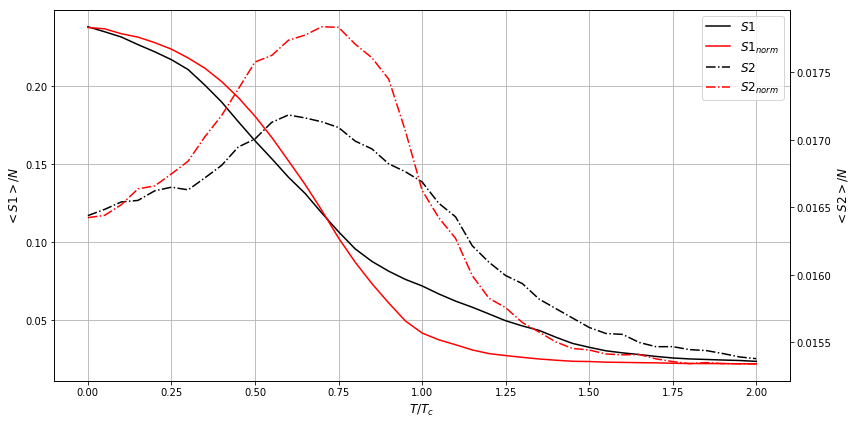

In [112]:
fig, ax1 = plt.subplots(figsize=(12,6))
plt.grid()

ax1.plot(Ts/Tc, S1, label=r'$S1$', c='black')
ax1.plot(Ts/Tc, S1_norm, label=r'$S1_{norm}$', c='red')
ax1.set_xlabel(r'$T/T_c$', fontsize=12)
ax1.set_ylabel(r'$<S1>/N$', fontsize=12)

ax2 = ax1.twinx()
ax2.plot(Ts/Tc, S2, '-.', label=r'$S2$', c='black')
ax2.plot(Ts/Tc, S2_norm, '-.', label=r'$S2_{norm}$', c='red')
ax2.set_ylabel(r'$<S2>/N$', fontsize=12)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, fontsize=12)

fig.tight_layout()
plt.show()

In [64]:
size = [x[0] for x in pdf[len(Ts)//2].most_common()]
counts = [x[1] for x in pdf[len(Ts)//2].most_common()]

size_norm = [x[0] for x in pdf_norm[len(Ts)//2].most_common()]
counts_norm = [x[1] for x in pdf_norm[len(Ts)//2].most_common()]

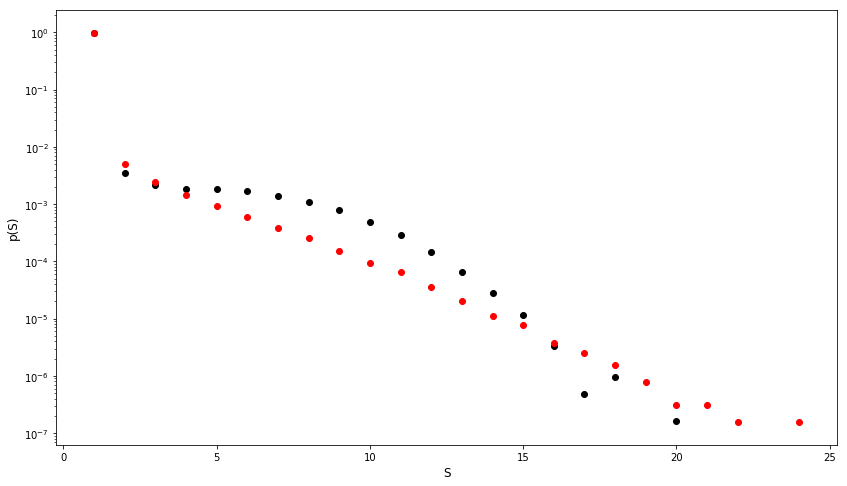

In [99]:
plt.figure(figsize=(14,8))

plt.yscale('log')

plt.scatter(size,[x/sum(counts) for x in counts], c='black')
plt.scatter(size_norm, [x/sum(counts_norm) for x in counts_norm], c='red')

plt.xlabel('S', size=12)
plt.ylabel('p(S)', size=12)

plt.show()

In [57]:
# SAVE SIMULATED DATA

folder = 'results/'

np.savetxt(folder+'activity.txt', (A,sigma_A,S1,S2), fmt='%e')
with open(folder+'pdf.txt', 'w') as outfile:
    for x in pdf:
        np.savetxt(outfile, np.asarray(x.most_common()))
        outfile.write('\n')
        
np.savetxt(folder+'activity_norm.txt', (A_norm,sigma_A_norm,S1_norm,S2_norm), fmt='%e')
with open(folder+'pdf_norm.txt', 'w') as outfile:
    for x in pdf_norm:
        np.savetxt(outfile, np.asarray(x.most_common()))
        outfile.write('\n')